In [58]:
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, accuracy_score

from proj2.config import HEART_DATA_FILE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Add, Activation
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

### Data Import

In [59]:
import pandas as pd

df = pd.read_csv(HEART_DATA_FILE)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Q1 - Data Exploration

#### Feature Overview

In [60]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


#### Check Missing Values & Data Types

In [61]:
# Check for missing values
print(df.isnull().sum())

# Data types
print(df.dtypes)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


#### Class Distribution

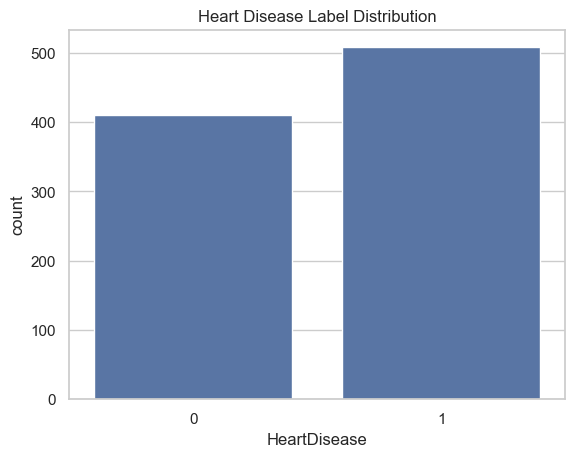

HeartDisease
1    55.337691
0    44.662309
Name: proportion, dtype: float64

In [62]:
sns.countplot(data=df, x='HeartDisease')
plt.title("Heart Disease Label Distribution")
plt.show()

# Percent breakdown
df['HeartDisease'].value_counts(normalize=True) * 100

#### Distribution of Numerical Features

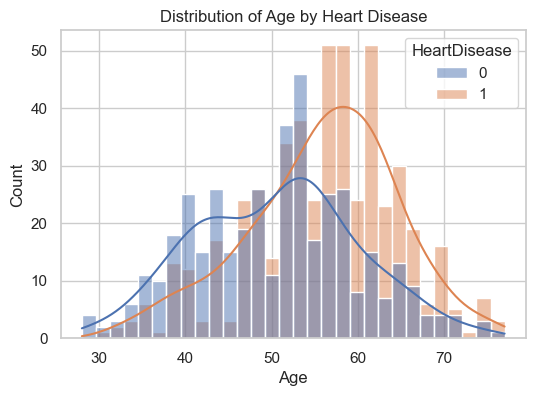

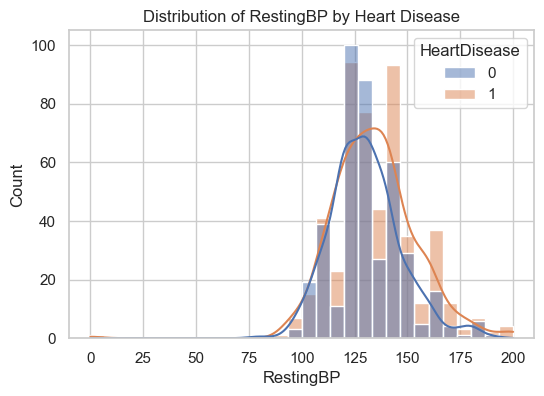

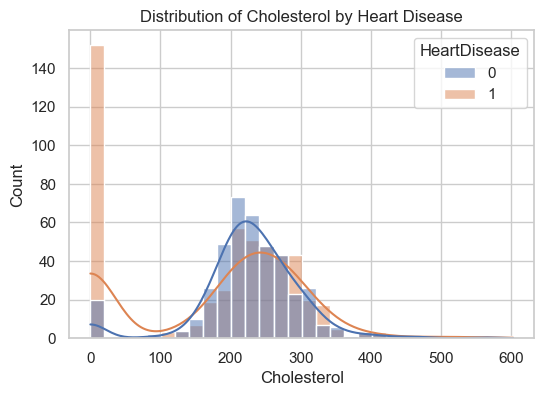

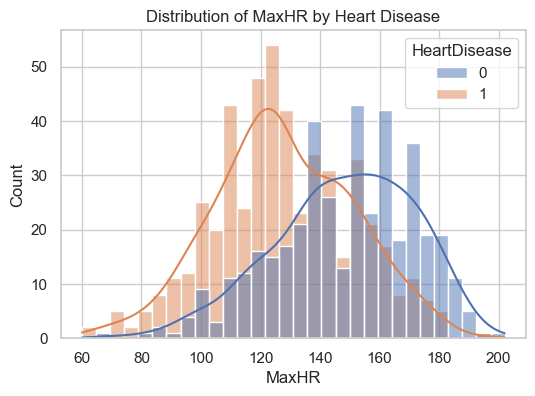

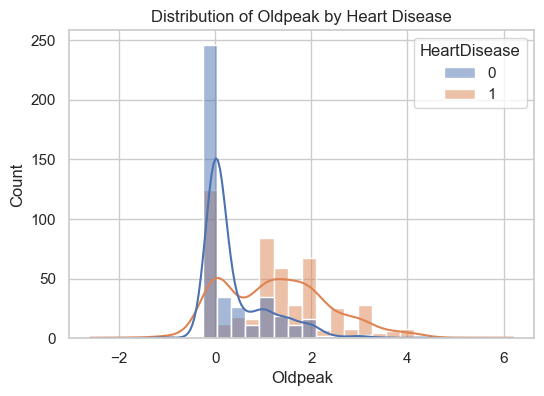

In [63]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df, x=col, hue="HeartDisease", kde=True, bins=30)
    plt.title(f'Distribution of {col} by Heart Disease')
    plt.show()

In [64]:
age_means = df.groupby('HeartDisease')['Age'].mean()

mean_disease   = age_means.loc[1]
mean_no_disease = age_means.loc[0]

print(
    f"Age: Patients with heart disease are on average older "
    f"(mean = {mean_disease:.2f}) than those without "
    f"(mean = {mean_no_disease:.2f}), and the density peak shifts right."
)

Age: Patients with heart disease are on average older (mean = 55.90) than those without (mean = 50.55), and the density peak shifts right.


#### Outliers

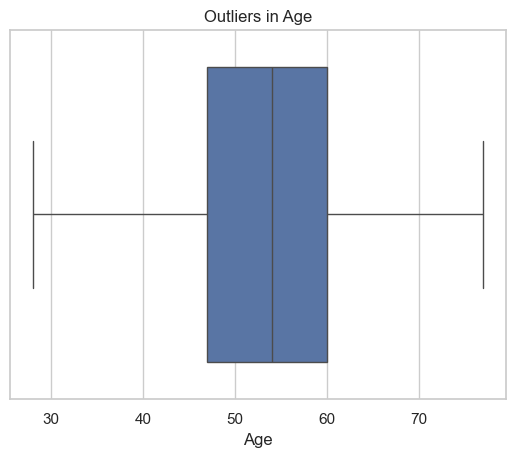

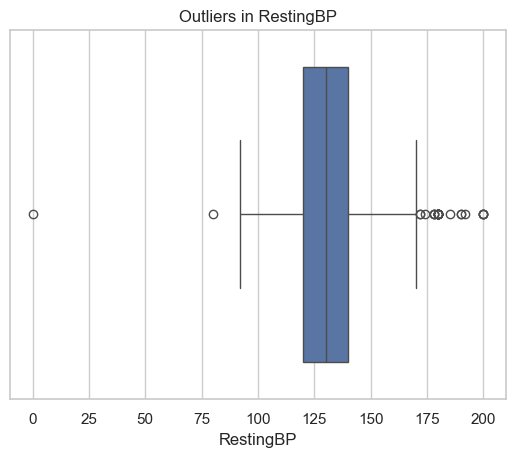

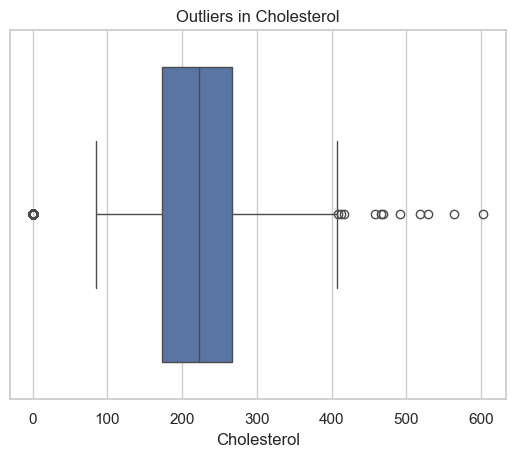

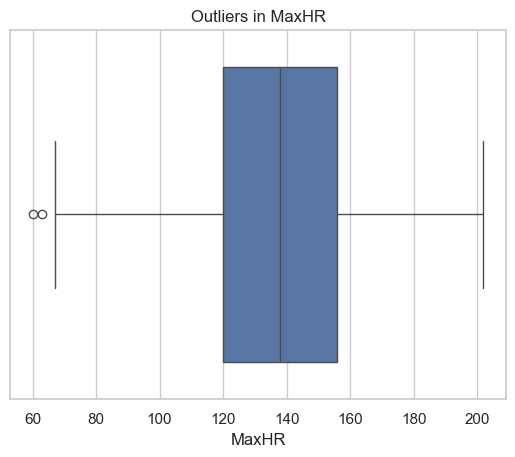

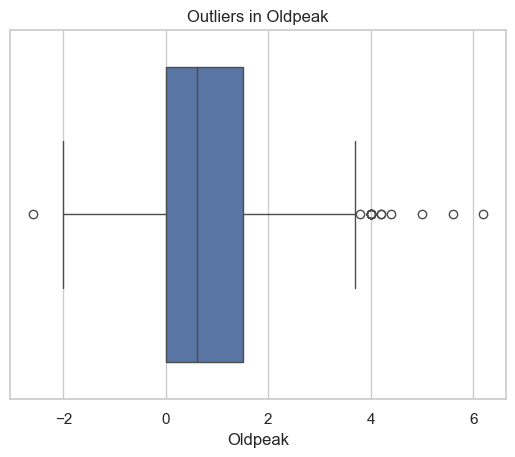

In [65]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
    plt.show()


In [66]:
print(f"Unrealistic Cholesterol values: {len(df[df['Cholesterol'] > 400])}")


Unrealistic Cholesterol values: 13


In [67]:
print(f"Unrealistic Oldpeak values: {len(df[df['Oldpeak'] < 0])}")

Unrealistic Oldpeak values: 13


In [68]:
print(f"Unrealistic RestingHB values: {len(df[df['RestingBP'] == 0])}")

Unrealistic RestingHB values: 1


#### Categorical Feature Counts

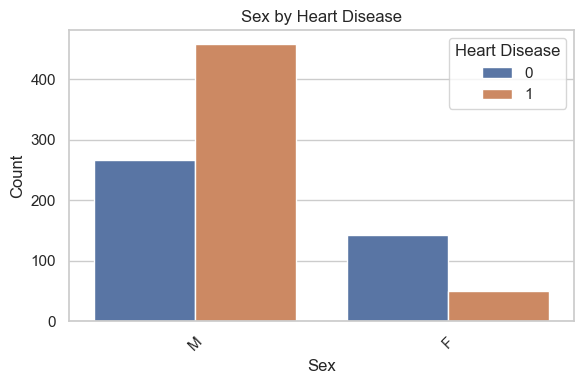

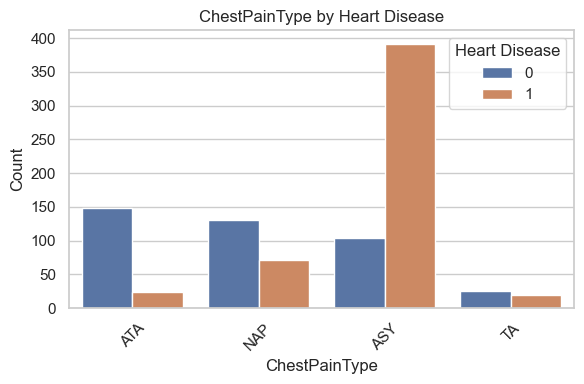

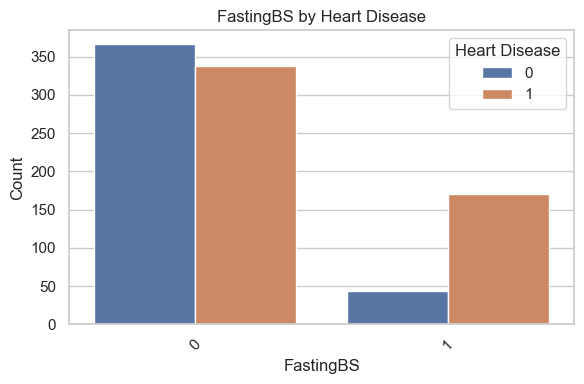

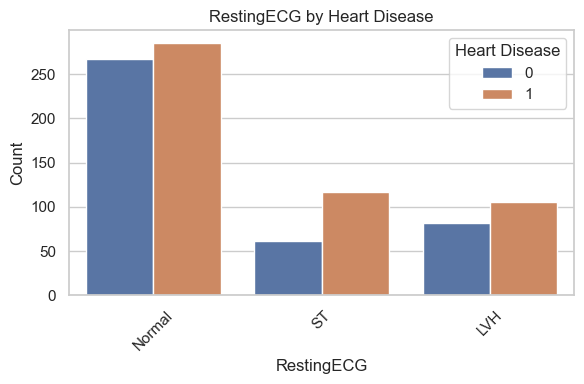

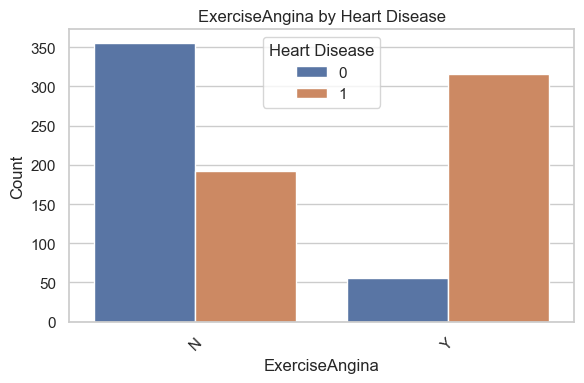

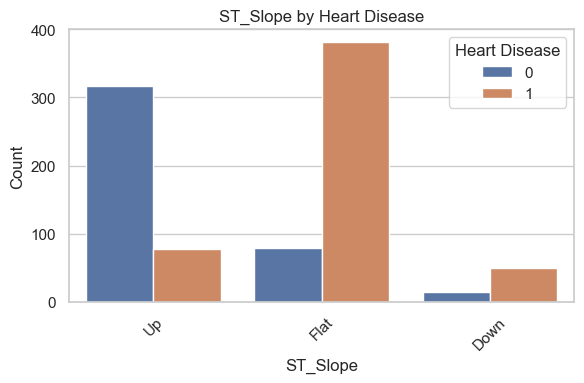

In [69]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS','RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='HeartDisease')
    plt.title(f"{col} by Heart Disease")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Heart Disease")
    plt.tight_layout()
    plt.show()

# Q1.3 - Data Preprocessing

In [70]:
df_encoded = df.copy()

# --- Binary variables (0/1) ---
binary_mapping = {
    'Sex': {'F': 0, 'M': 1},
    'ExerciseAngina': {'N': 0, 'Y': 1}
}
for col, mapping in binary_mapping.items():
    df_encoded[col] = df_encoded[col].map(mapping)

# --- Ordinal variable (ST_Slope) ---
ordinal_encoder = OrdinalEncoder(categories=[['Down', 'Flat', 'Up']])
df_encoded['ST_Slope'] = ordinal_encoder.fit_transform(df_encoded[['ST_Slope']])

# --- Nominal variables (one-hot) ---
nominal_cols = ['RestingECG', 'ChestPainType']
df_encoded = pd.get_dummies(df_encoded, columns=nominal_cols, drop_first=True)

# Check results
df_encoded.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingECG_Normal,RestingECG_ST,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,40,1,140,289,0,172,0,0.0,2.0,0,True,False,True,False,False
1,49,0,160,180,0,156,0,1.0,1.0,1,True,False,False,True,False
2,37,1,130,283,0,98,0,0.0,2.0,0,False,True,True,False,False
3,48,0,138,214,0,108,1,1.5,1.0,1,True,False,False,False,False
4,54,1,150,195,0,122,0,0.0,2.0,0,True,False,False,True,False


#### Impute Nonsensical Values

In [71]:
df_imputation = df_encoded.copy()
df_imputation['Cholesterol'] = df_imputation['Cholesterol'].replace(0, np.nan)
df_imputation['RestingBP'] = df_imputation['RestingBP'].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=5)
df_imputation_array = imputer.fit_transform(df_imputation)
df_imputation = pd.DataFrame(df_imputation_array, columns=df_imputation.columns)


In [72]:
df_imputation.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingECG_Normal,RestingECG_ST,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,40.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0
1,49.0,0.0,160.0,180.0,0.0,156.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
2,37.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0
3,48.0,0.0,138.0,214.0,0.0,108.0,1.0,1.5,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,54.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0


Any remaining NaNs in Cholesterol? 0


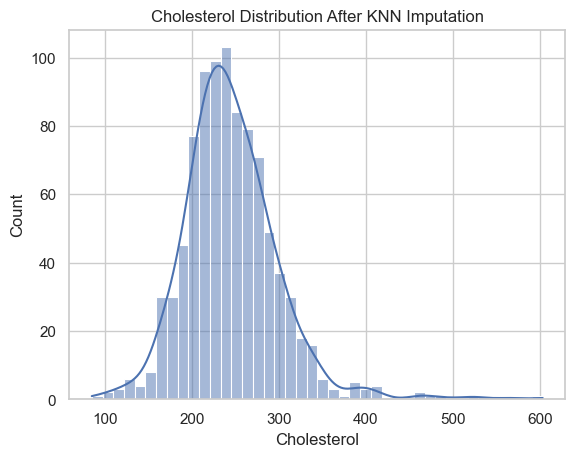

In [73]:
print("Any remaining NaNs in Cholesterol?", df_imputation['Cholesterol'].isna().sum())
sns.histplot(df_imputation['Cholesterol'], kde=True)
plt.title("Cholesterol Distribution After KNN Imputation")
plt.show()


#### Outlier handeling

In [74]:
q99 = df_imputation['Cholesterol'].quantile(0.99)
df_imputation['Cholesterol'] = np.where(df_imputation['Cholesterol'] > q99, q99, df_imputation['Cholesterol'])

In [75]:
df_imputation['Oldpeak'] = df_imputation['Oldpeak'].apply(lambda x: 0 if x < 0 else x)

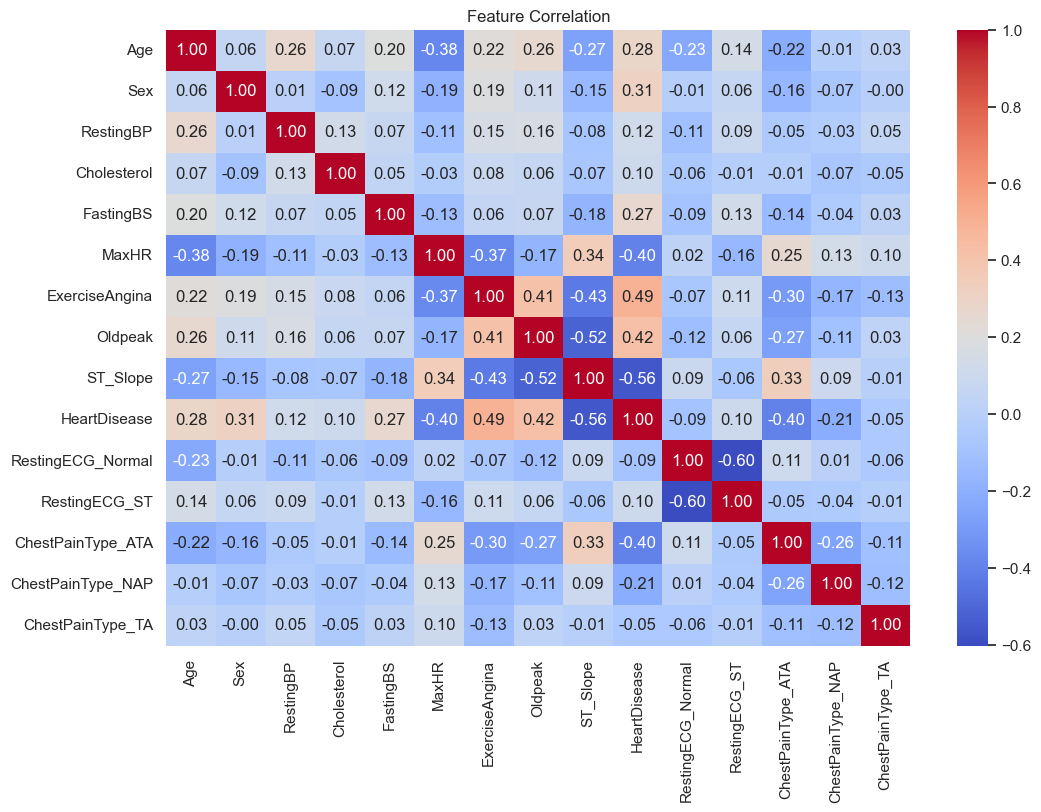

In [76]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_imputation.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation")
plt.show()

In [77]:
# Feature scaling
features = df_imputation.drop("HeartDisease", axis=1)
target = df_imputation["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X = df_imputation.drop("HeartDisease", axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit ONLY on train
X_test = scaler.transform(X_test)       # Transform test using train's mean/std

---
# Q2 - Logistic Lasso Regression
#### Fit Lasso Logistic Model

In [78]:
# L1-regularized logistic regression (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

## Q2.2  
The preprocessing steps which are crucial are the imputing, since otherwise we can not feed the model with data, outlier handling, since otherwise the generalization is less stable. Further, we need to encode categorical variables into numerical ones and split the data into training and testing datasets. Finally,  standardization is crucial, since the magnitude might make the model less precise. 

---
## Q2.3
#### Performance 

In [79]:
y_pred = lasso_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


F1 Score: 0.886
Balanced Accuracy: 0.864

Classification Report:

              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85        82
         1.0       0.86      0.91      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



---
## Q2.4
#### Visualization of Feature Importance

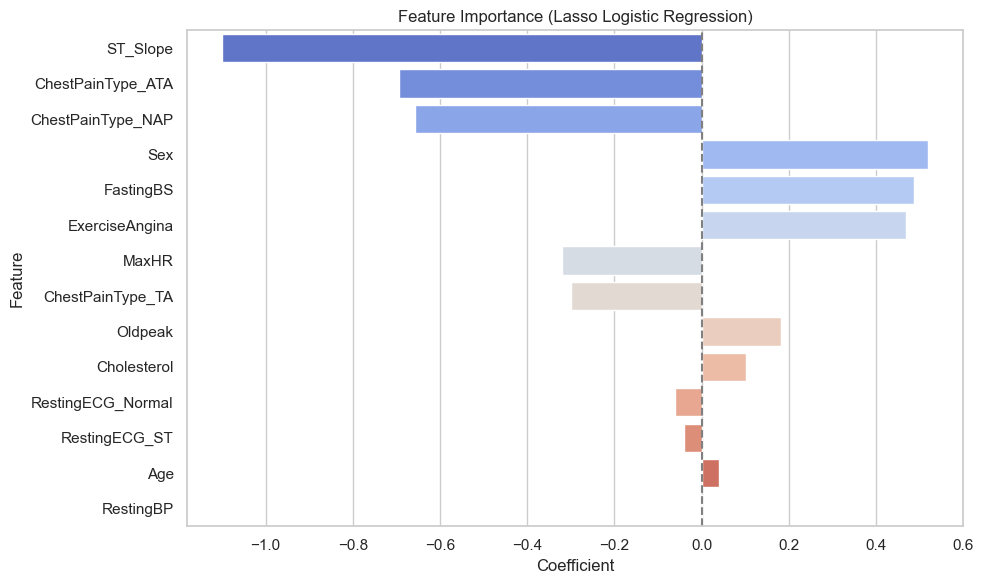

In [80]:
# Get feature names and corresponding coefficients
feature_names = X.columns
coefficients = lasso_model.coef_[0]

# Create a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
# Sort by absolute importance
coef_df = coef_df.sort_values(by="Coefficient", key=lambda x: np.abs(x), ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Feature Importance (Lasso Logistic Regression)")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

## Q2.5
Refitting a standard logistic regression on Lasso‐selected variables may yield a simpler model, but it breaks formal statistical inference. In a purely predictive machine learning context, one could select the model with the highest cross-validated accuracy. However, for statistical interpretation and hypothesis testing, this two‐stage approach invalidates p‐values and confidence intervals because it ignores the uncertainty introduced by feature selection. Moreover, Lasso can drop genuine confounders under penalty, biasing coefficients in the refit. So overall it is recommended to use the full lasso model. 

# Q3 - Multi-Layer Perceptrons
## Q3.1 MLP Training

In [81]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)


#### Evaluation

In [82]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
F1 Score: 0.8792270531400966
Accuracy: 0.8641304347826086
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84        82
         1.0       0.87      0.89      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



---
## Q3.2 SHAP Explanations

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/4 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 606us/step


 25%|██▌       | 1/4 [00:36<01:50, 36.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 562us/step


 50%|█████     | 2/4 [01:12<01:12, 36.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 585us/step


 75%|███████▌  | 3/4 [01:49<00:36, 36.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 618us/step


100%|██████████| 4/4 [02:27<00:00, 36.91s/it]


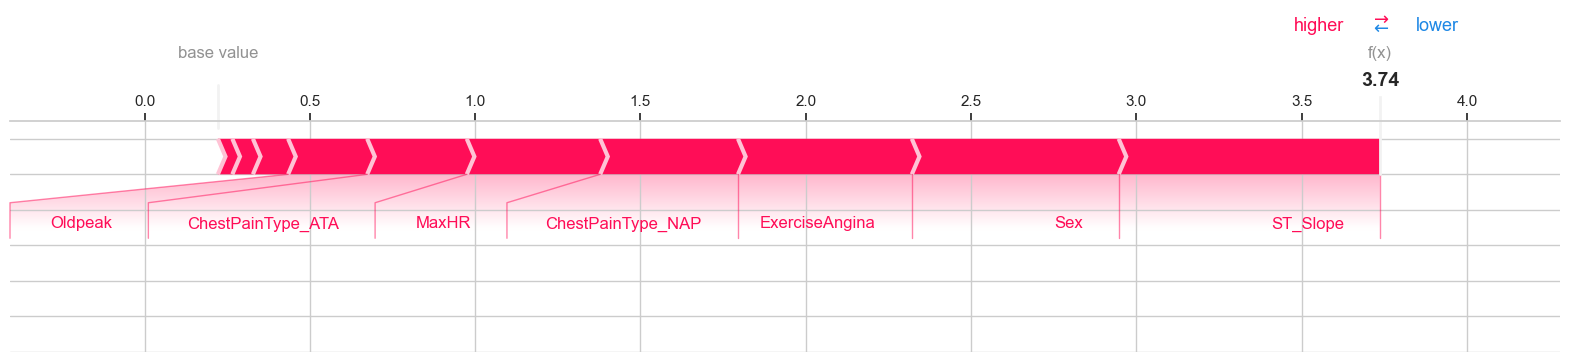

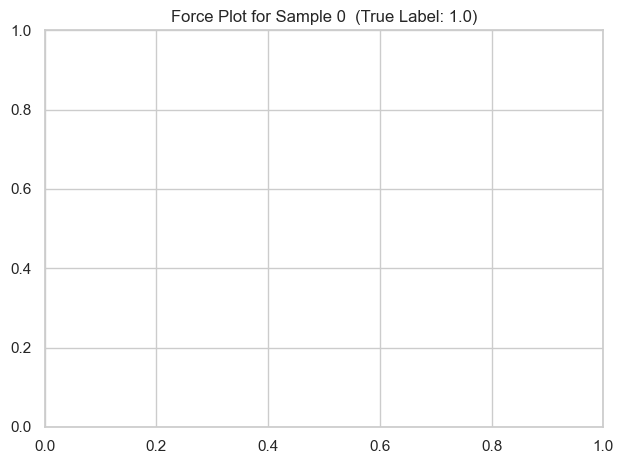

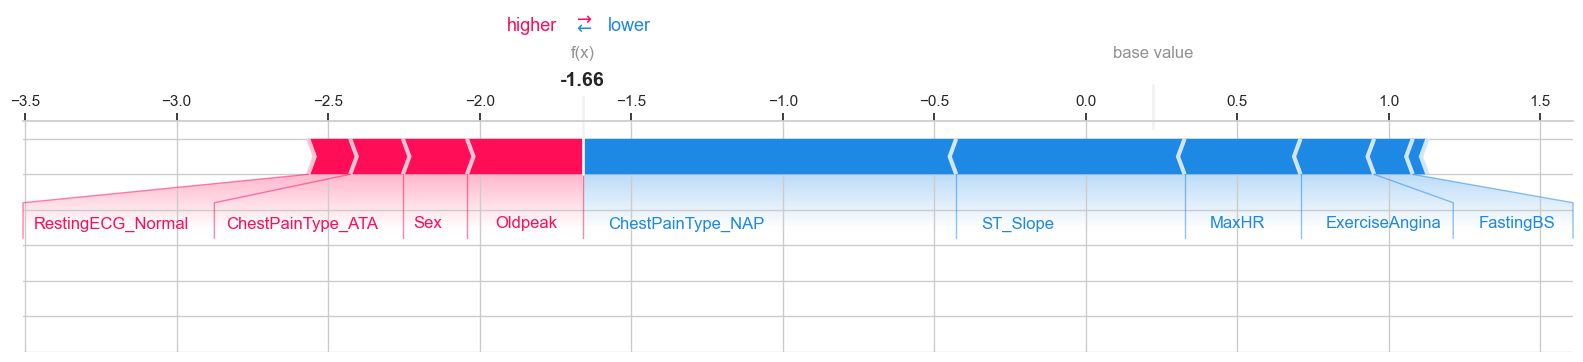

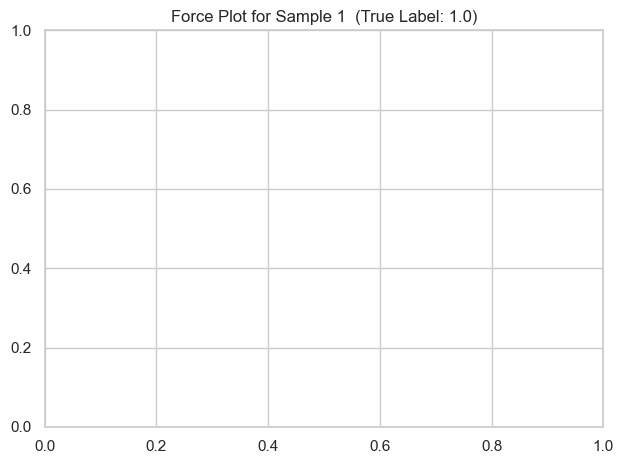

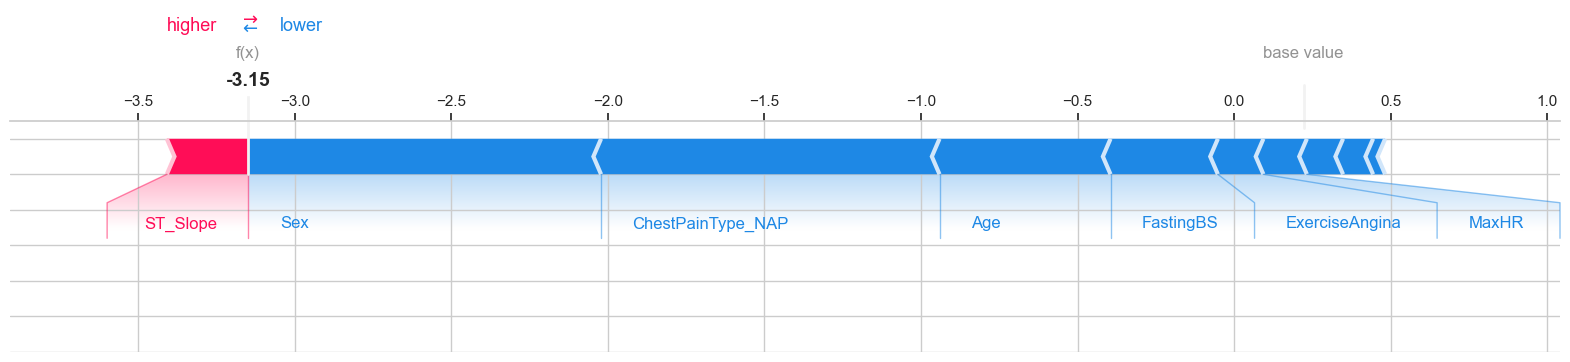

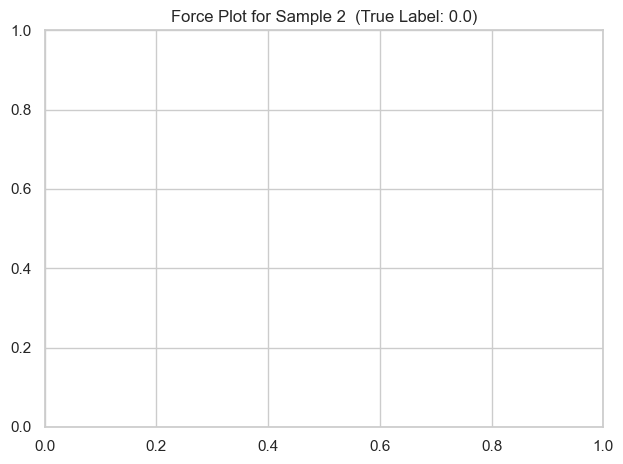

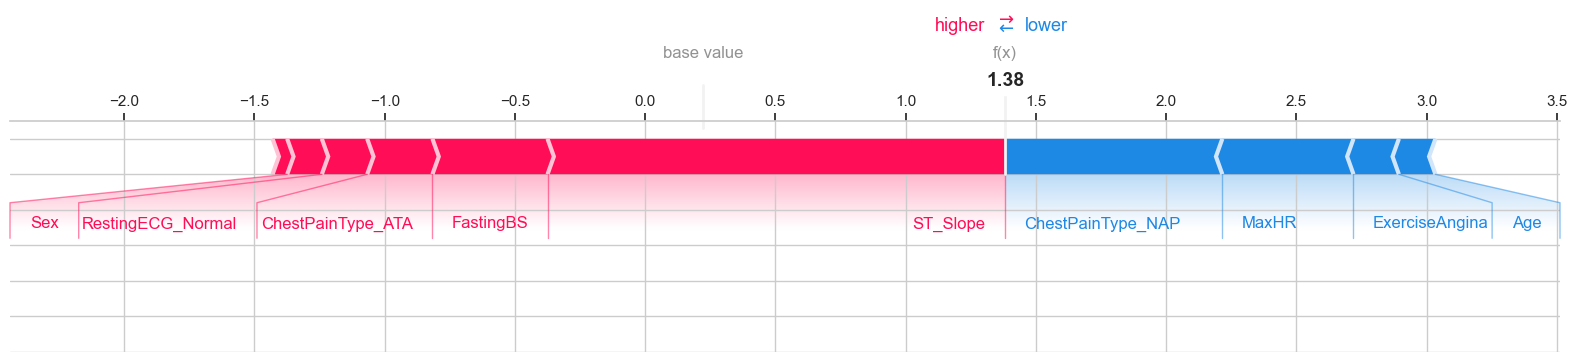

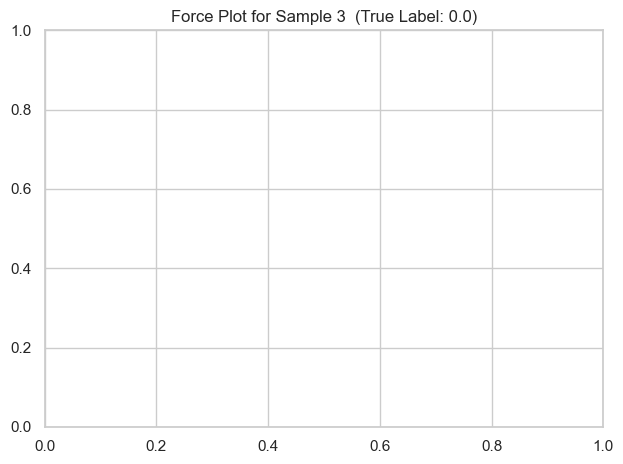

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# wrap model.predict to return flat probabilities
predict_proba_fn = lambda X: model.predict(X).ravel()

# create KernelExplainer
explainer = shap.KernelExplainer(predict_proba_fn, X_train, link="logit")

# pick 2 positives, 2 negatives
pos_idx = np.where(y_test.values == 1)[0][:2]
neg_idx = np.where(y_test.values == 0)[0][:2]
sample_indices = np.concatenate([pos_idx, neg_idx])
X_sample = X_test[sample_indices]

# compute SHAP
shap_values = explainer.shap_values(X_sample)
if isinstance(shap_values, list):
    shap_vals = shap_values[0]
    base_val = explainer.expected_value[0]
else:
    shap_vals = shap_values
    base_val = explainer.expected_value

# init JS (only needed for notebook interactivity)
shap.initjs()

# plot force plots *without* feature values
for i, idx in enumerate(sample_indices):
    # pass data=None so feature values aren’t shown
    expl = shap.Explanation(
        values=shap_vals[i],
        base_values=base_val,
        data=None,
        feature_names=X.columns
    )
    shap.plots.force(expl, matplotlib=True)
    plt.title(f"Force Plot for Sample {i}  (True Label: {y_test.values[idx]})")
    plt.tight_layout()
    plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/4 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 577us/step


 25%|██▌       | 1/4 [00:35<01:47, 35.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 583us/step


 50%|█████     | 2/4 [01:11<01:11, 35.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 607us/step


 75%|███████▌  | 3/4 [01:49<00:36, 36.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 579us/step


100%|██████████| 4/4 [02:24<00:00, 36.21s/it]


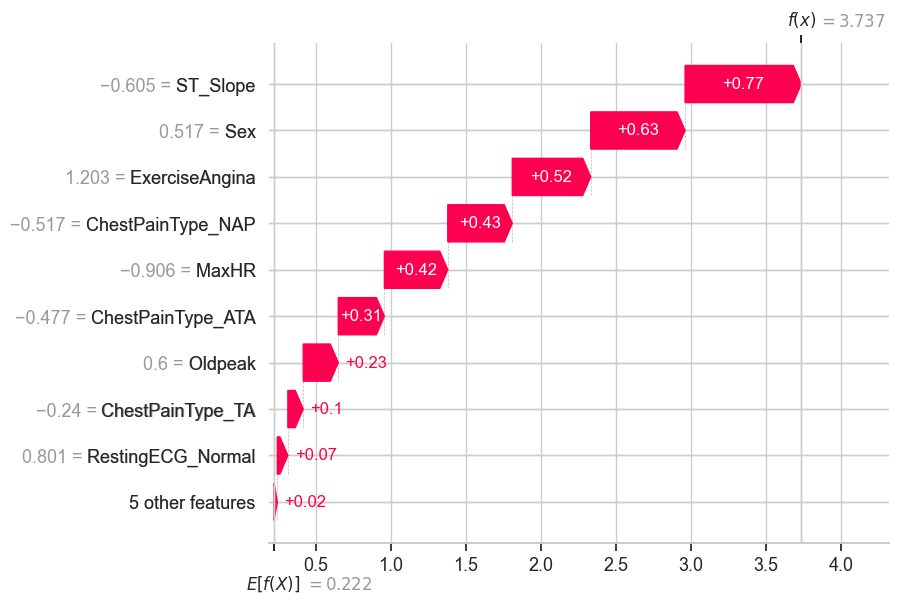

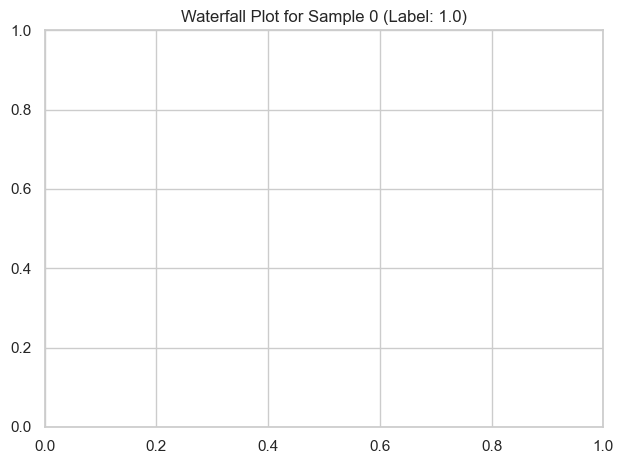

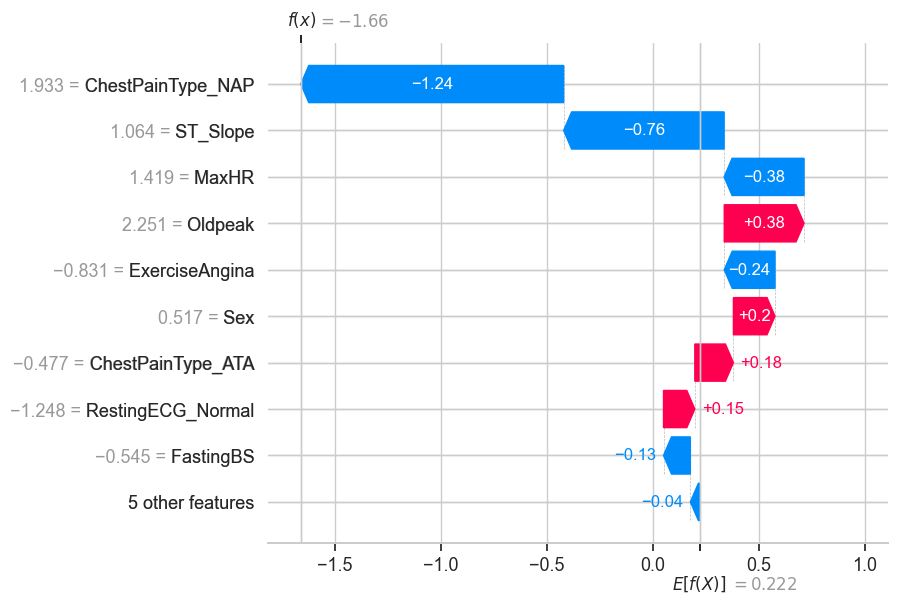

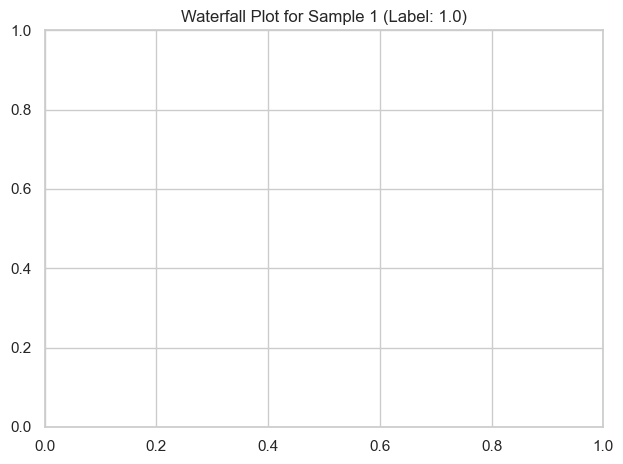

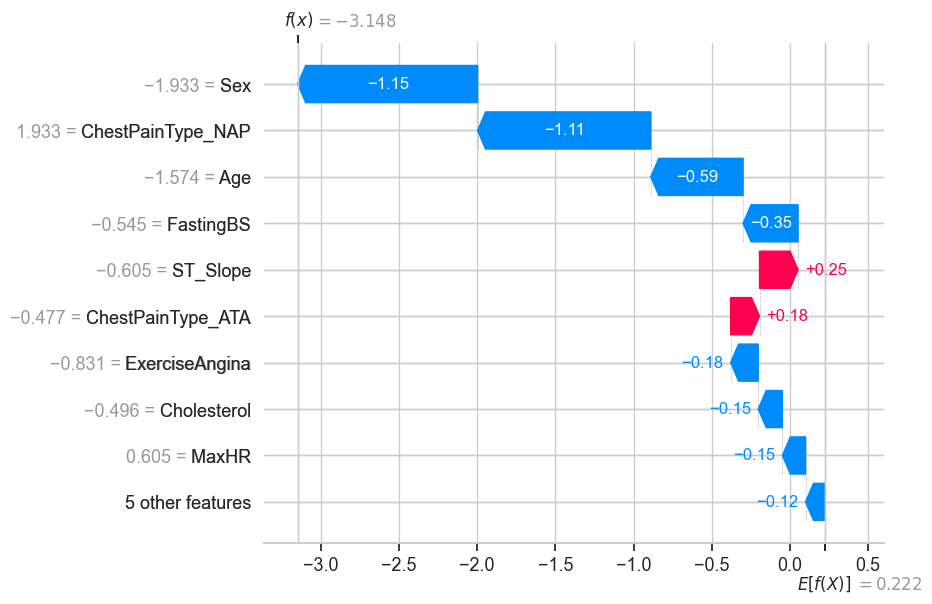

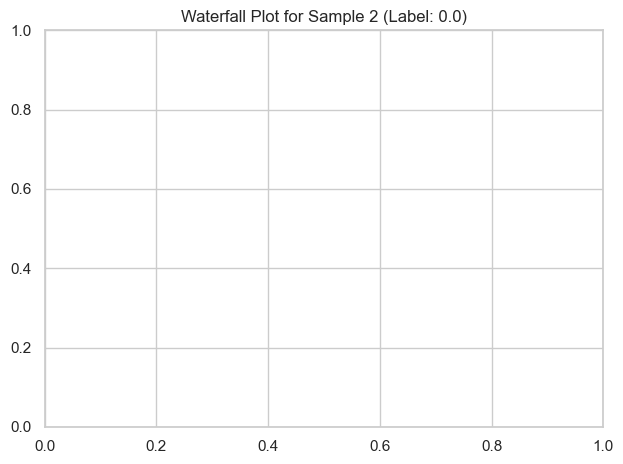

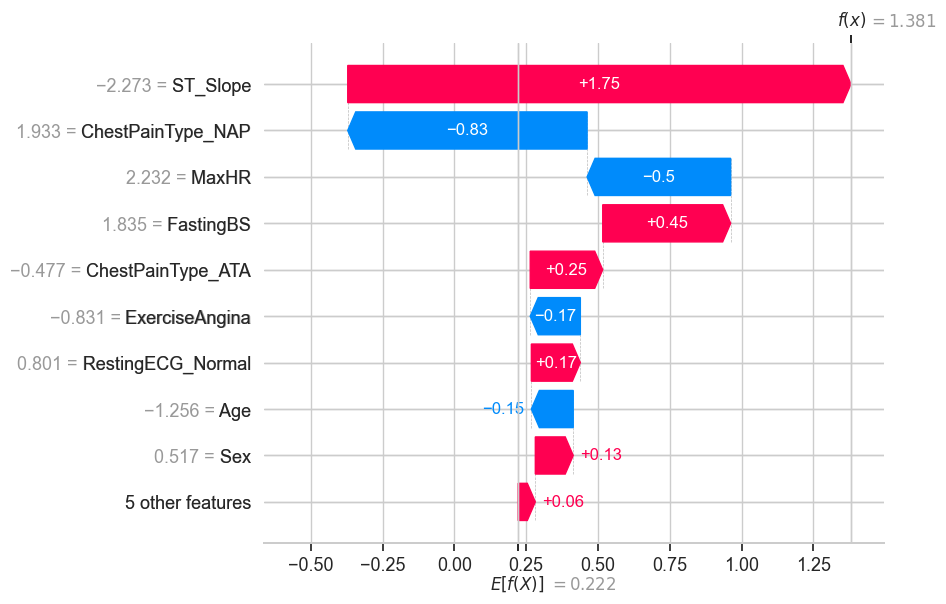

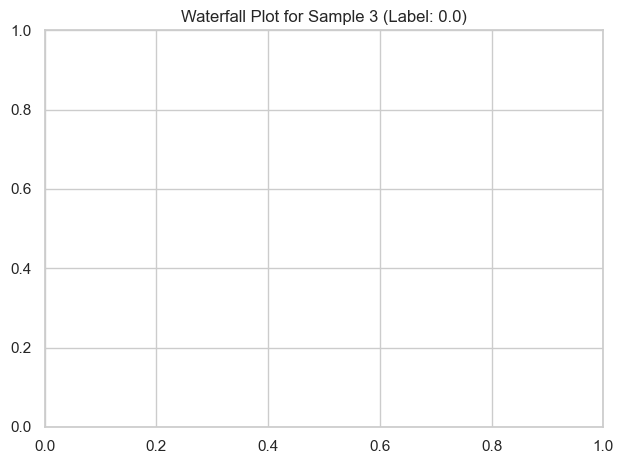

In [84]:
# 1) wrap model.predict to return flat probabilities
predict_proba_fn = lambda X: model.predict(X).ravel()

# 2) create SHAP KernelExplainer
explainer = shap.KernelExplainer(
    predict_proba_fn,
    X_train,
    link="logit"
)

# 3) select 2 positive and 2 negative samples
pos_idx = np.where(y_test.values == 1)[0][:2]
neg_idx = np.where(y_test.values == 0)[0][:2]
sample_indices = np.concatenate([pos_idx, neg_idx])
X_sample = X_test[sample_indices]

# 4) compute SHAP values
shap_values = explainer.shap_values(X_sample)

# 5) unpack values if KernelExplainer returns a list
if isinstance(shap_values, list):
    shap_vals = shap_values[0]
    base_val = explainer.expected_value[0]
else:
    shap_vals = shap_values
    base_val = explainer.expected_value

# 6) plot SHAP waterfall for each sample
for i in range(X_sample.shape[0]):
    expl = shap.Explanation(
        values=shap_vals[i],
        base_values=base_val,
        data=X_sample[i],
        feature_names=X.columns
    )
    shap.plots.waterfall(expl)
    plt.title(f"Waterfall Plot for Sample {i} (Label: {y_test.values[sample_indices[i]]})")
    plt.tight_layout()
    plt.show()
    

  0%|          | 0/184 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 579us/step


  1%|          | 1/184 [00:36<1:50:40, 36.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 599us/step


  1%|          | 2/184 [01:13<1:50:53, 36.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 581us/step


  2%|▏         | 3/184 [01:48<1:49:08, 36.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 576us/step


  2%|▏         | 4/184 [02:24<1:48:08, 36.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 578us/step


  3%|▎         | 5/184 [03:00<1:47:44, 36.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 581us/step


  3%|▎         | 6/184 [03:36<1:46:42, 35.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 587us/step


  4%|▍         | 7/184 [04:12<1:46:05, 35.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 577us/step


  4%|▍         | 8/184 [04:48<1:45:15, 35.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 588us/step


  5%|▍         | 9/184 [05:25<1:45:38, 36.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 580us/step


  5%|▌         | 10/184 [06:00<1:44:31, 36.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 582us/step


  6%|▌         | 11/184 [06:36<1:43:48, 36.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 578us/step


  7%|▋         | 12/184 [07:12<1:42:41, 35.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 581us/step


  7%|▋         | 13/184 [07:47<1:42:07, 35.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 579us/step


  8%|▊         | 14/184 [08:23<1:41:21, 35.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 584us/step


  8%|▊         | 15/184 [08:59<1:40:53, 35.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 602us/step


  9%|▊         | 16/184 [09:36<1:41:06, 36.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 598us/step


  9%|▉         | 17/184 [10:12<1:40:52, 36.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 588us/step


 10%|▉         | 18/184 [10:48<1:40:05, 36.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 579us/step


 10%|█         | 19/184 [11:24<1:38:56, 35.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 599us/step


 11%|█         | 20/184 [12:01<1:39:05, 36.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 26s 554us/step


 11%|█▏        | 21/184 [12:38<1:39:24, 36.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 474us/step


 12%|█▏        | 22/184 [13:09<1:33:48, 34.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 447us/step


 12%|█▎        | 23/184 [13:38<1:28:57, 33.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 452us/step


 13%|█▎        | 24/184 [14:08<1:25:30, 32.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 455us/step


 14%|█▎        | 25/184 [14:37<1:23:00, 31.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 441us/step


 14%|█▍        | 26/184 [15:06<1:20:38, 30.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 452us/step


 15%|█▍        | 27/184 [15:36<1:19:07, 30.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 448us/step


 15%|█▌        | 28/184 [16:05<1:17:55, 29.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 444us/step


 16%|█▌        | 29/184 [16:34<1:16:39, 29.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 442us/step


 16%|█▋        | 30/184 [17:03<1:15:37, 29.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 475us/step


 17%|█▋        | 31/184 [17:33<1:16:01, 29.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 446us/step


 17%|█▋        | 32/184 [18:03<1:15:10, 29.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 454us/step


 18%|█▊        | 33/184 [18:32<1:14:30, 29.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 445us/step


 18%|█▊        | 34/184 [19:02<1:13:55, 29.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 452us/step


 19%|█▉        | 35/184 [19:32<1:13:54, 29.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 443us/step


 20%|█▉        | 36/184 [20:01<1:12:50, 29.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 467us/step


 20%|██        | 37/184 [20:31<1:12:48, 29.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 476us/step


 21%|██        | 38/184 [21:01<1:12:37, 29.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 21%|██        | 39/184 [21:28<1:09:52, 28.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 22%|██▏       | 40/184 [21:54<1:07:36, 28.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 22%|██▏       | 41/184 [22:21<1:06:08, 27.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 409us/step


 23%|██▎       | 42/184 [22:48<1:05:03, 27.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 406us/step


 23%|██▎       | 43/184 [23:15<1:04:05, 27.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 407us/step


 24%|██▍       | 44/184 [23:41<1:03:12, 27.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 411us/step


 24%|██▍       | 45/184 [24:08<1:02:35, 27.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 412us/step


 25%|██▌       | 46/184 [24:35<1:02:10, 27.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 426us/step


 26%|██▌       | 47/184 [25:03<1:02:04, 27.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 406us/step


 26%|██▌       | 48/184 [25:30<1:01:15, 27.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 408us/step


 27%|██▋       | 49/184 [25:56<1:00:35, 26.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 403us/step


 27%|██▋       | 50/184 [26:23<59:44, 26.75s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 28%|██▊       | 51/184 [26:49<59:00, 26.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 408us/step


 28%|██▊       | 52/184 [27:16<58:34, 26.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 400us/step


 29%|██▉       | 53/184 [27:42<57:52, 26.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 29%|██▉       | 54/184 [28:08<57:22, 26.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 400us/step


 30%|██▉       | 55/184 [28:35<56:50, 26.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 481us/step


 30%|███       | 56/184 [29:06<59:18, 27.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 431us/step


 31%|███       | 57/184 [29:33<58:52, 27.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 427us/step


 32%|███▏      | 58/184 [30:01<58:20, 27.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 32%|███▏      | 59/184 [30:27<56:58, 27.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 403us/step


 33%|███▎      | 60/184 [30:54<55:57, 27.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 412us/step


 33%|███▎      | 61/184 [31:21<55:21, 27.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 34%|███▎      | 62/184 [31:47<54:32, 26.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 34%|███▍      | 63/184 [32:14<53:54, 26.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 35%|███▍      | 64/184 [32:40<53:09, 26.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 397us/step


 35%|███▌      | 65/184 [33:06<52:33, 26.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 398us/step


 36%|███▌      | 66/184 [33:32<51:54, 26.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 431us/step


 36%|███▋      | 67/184 [34:02<53:19, 27.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 440us/step


 37%|███▋      | 68/184 [34:31<53:49, 27.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 38%|███▊      | 69/184 [34:58<52:47, 27.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 411us/step


 38%|███▊      | 70/184 [35:25<52:00, 27.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 410us/step


 39%|███▊      | 71/184 [35:52<51:18, 27.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 39%|███▉      | 72/184 [36:19<50:47, 27.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 412us/step


 40%|███▉      | 73/184 [36:46<50:15, 27.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 421us/step


 40%|████      | 74/184 [37:13<49:59, 27.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 411us/step


 41%|████      | 75/184 [37:41<49:36, 27.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 417us/step


 41%|████▏     | 76/184 [38:08<49:16, 27.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 409us/step


 42%|████▏     | 77/184 [38:36<48:47, 27.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 412us/step


 42%|████▏     | 78/184 [39:03<48:20, 27.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 43%|████▎     | 79/184 [39:30<47:47, 27.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 409us/step


 43%|████▎     | 80/184 [39:57<47:08, 27.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 44%|████▍     | 81/184 [40:24<46:23, 27.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 409us/step


 45%|████▍     | 82/184 [40:52<46:20, 27.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 461us/step


 45%|████▌     | 83/184 [41:21<47:02, 27.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 407us/step


 46%|████▌     | 84/184 [41:48<45:57, 27.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 46%|████▌     | 85/184 [42:14<45:00, 27.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 440us/step


 47%|████▋     | 86/184 [42:43<45:01, 27.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 410us/step


 47%|████▋     | 87/184 [43:10<44:16, 27.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 411us/step


 48%|████▊     | 88/184 [43:36<43:34, 27.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 48%|████▊     | 89/184 [44:03<42:53, 27.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 49%|████▉     | 90/184 [44:30<42:13, 26.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 403us/step


 49%|████▉     | 91/184 [44:57<41:40, 26.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 413us/step


 50%|█████     | 92/184 [45:24<41:18, 26.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 399us/step


 51%|█████     | 93/184 [45:50<40:30, 26.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 403us/step


 51%|█████     | 94/184 [46:16<39:54, 26.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 403us/step


 52%|█████▏    | 95/184 [46:43<39:22, 26.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 412us/step


 52%|█████▏    | 96/184 [47:09<39:02, 26.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 53%|█████▎    | 97/184 [47:36<38:28, 26.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 406us/step


 53%|█████▎    | 98/184 [48:02<38:04, 26.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 54%|█████▍    | 99/184 [48:29<37:30, 26.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 406us/step


 54%|█████▍    | 100/184 [48:55<37:11, 26.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 444us/step


 55%|█████▍    | 101/184 [49:24<37:32, 27.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 55%|█████▌    | 102/184 [49:51<36:57, 27.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 400us/step


 56%|█████▌    | 103/184 [50:17<36:11, 26.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 407us/step


 57%|█████▋    | 104/184 [50:44<35:37, 26.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 57%|█████▋    | 105/184 [51:10<35:05, 26.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 58%|█████▊    | 106/184 [51:36<34:31, 26.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 407us/step


 58%|█████▊    | 107/184 [52:03<34:06, 26.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 408us/step


 59%|█████▊    | 108/184 [52:30<33:40, 26.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 59%|█████▉    | 109/184 [52:56<33:12, 26.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 424us/step


 60%|█████▉    | 110/184 [53:24<33:05, 26.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 408us/step


 60%|██████    | 111/184 [53:50<32:35, 26.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 404us/step


 61%|██████    | 112/184 [54:17<32:00, 26.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 406us/step


 61%|██████▏   | 113/184 [54:43<31:30, 26.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 403us/step


 62%|██████▏   | 114/184 [55:10<30:59, 26.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 398us/step


 62%|██████▎   | 115/184 [55:36<30:28, 26.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 400us/step


 63%|██████▎   | 116/184 [56:02<29:56, 26.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 403us/step


 64%|██████▎   | 117/184 [56:29<29:32, 26.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 410us/step


 64%|██████▍   | 118/184 [56:56<29:16, 26.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 411us/step


 65%|██████▍   | 119/184 [57:23<28:57, 26.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 65%|██████▌   | 120/184 [57:49<28:22, 26.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 398us/step


 66%|██████▌   | 121/184 [58:15<27:46, 26.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 66%|██████▋   | 122/184 [58:41<27:18, 26.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 67%|██████▋   | 123/184 [59:08<26:50, 26.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 410us/step


 67%|██████▋   | 124/184 [59:34<26:28, 26.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 403us/step


 68%|██████▊   | 125/184 [1:00:01<26:02, 26.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 409us/step


 68%|██████▊   | 126/184 [1:00:28<25:38, 26.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 69%|██████▉   | 127/184 [1:00:54<25:10, 26.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 418us/step


 70%|██████▉   | 128/184 [1:01:21<24:54, 26.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 70%|███████   | 129/184 [1:01:47<24:22, 26.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 71%|███████   | 130/184 [1:02:14<23:53, 26.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 71%|███████   | 131/184 [1:02:40<23:26, 26.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 72%|███████▏  | 132/184 [1:03:07<23:03, 26.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 72%|███████▏  | 133/184 [1:03:33<22:31, 26.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 73%|███████▎  | 134/184 [1:04:00<22:07, 26.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 73%|███████▎  | 135/184 [1:04:26<21:36, 26.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 74%|███████▍  | 136/184 [1:04:53<21:08, 26.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 410us/step


 74%|███████▍  | 137/184 [1:05:20<20:47, 26.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 406us/step


 75%|███████▌  | 138/184 [1:05:46<20:20, 26.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 399us/step


 76%|███████▌  | 139/184 [1:06:12<19:48, 26.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 400us/step


 76%|███████▌  | 140/184 [1:06:38<19:20, 26.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 400us/step


 77%|███████▋  | 141/184 [1:07:05<18:52, 26.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 402us/step


 77%|███████▋  | 142/184 [1:07:31<18:26, 26.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 406us/step


 78%|███████▊  | 143/184 [1:07:58<18:04, 26.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 405us/step


 78%|███████▊  | 144/184 [1:08:24<17:37, 26.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 404us/step


 79%|███████▉  | 145/184 [1:08:51<17:12, 26.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 430us/step


 79%|███████▉  | 146/184 [1:09:19<17:00, 26.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 404us/step


 80%|███████▉  | 147/184 [1:09:45<16:29, 26.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 408us/step


 80%|████████  | 148/184 [1:10:12<16:01, 26.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 81%|████████  | 149/184 [1:10:38<15:30, 26.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 408us/step


 82%|████████▏ | 150/184 [1:11:05<15:04, 26.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 19s 401us/step


 82%|████████▏ | 151/184 [1:11:33<14:51, 27.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 26s 556us/step


 83%|████████▎ | 152/184 [1:12:09<15:58, 29.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 563us/step


 83%|████████▎ | 153/184 [1:12:44<16:09, 31.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 576us/step


 84%|████████▎ | 154/184 [1:13:19<16:12, 32.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 566us/step


 84%|████████▍ | 155/184 [1:13:53<15:57, 33.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 563us/step


 85%|████████▍ | 156/184 [1:14:27<15:34, 33.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 26s 551us/step


 85%|████████▌ | 157/184 [1:15:02<15:07, 33.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 562us/step


 86%|████████▌ | 158/184 [1:15:36<14:42, 33.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 558us/step


 86%|████████▋ | 159/184 [1:16:10<14:08, 33.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 560us/step


 87%|████████▋ | 160/184 [1:16:44<13:36, 34.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 561us/step


 88%|████████▊ | 161/184 [1:17:19<13:03, 34.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 557us/step


 88%|████████▊ | 162/184 [1:17:53<12:29, 34.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 26s 554us/step


 89%|████████▊ | 163/184 [1:18:26<11:52, 33.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 26s 553us/step


 89%|████████▉ | 164/184 [1:19:00<11:19, 33.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 561us/step


 90%|████████▉ | 165/184 [1:19:35<10:46, 34.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 560us/step


 90%|█████████ | 166/184 [1:20:09<10:12, 34.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 562us/step


 91%|█████████ | 167/184 [1:20:43<09:38, 34.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 562us/step


 91%|█████████▏| 168/184 [1:21:17<09:06, 34.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 560us/step


 92%|█████████▏| 169/184 [1:21:51<08:31, 34.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 559us/step


 92%|█████████▏| 170/184 [1:22:25<07:57, 34.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 26s 555us/step


 93%|█████████▎| 171/184 [1:22:59<07:21, 33.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 26s 553us/step


 93%|█████████▎| 172/184 [1:23:33<06:46, 33.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 557us/step


 94%|█████████▍| 173/184 [1:24:06<06:12, 33.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 559us/step


 95%|█████████▍| 174/184 [1:24:41<05:39, 33.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 582us/step


 95%|█████████▌| 175/184 [1:25:17<05:13, 34.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 619us/step


 96%|█████████▌| 176/184 [1:25:55<04:44, 35.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 575us/step


 96%|█████████▌| 177/184 [1:26:30<04:08, 35.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 570us/step


 97%|█████████▋| 178/184 [1:27:05<03:32, 35.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 29s 600us/step


 97%|█████████▋| 179/184 [1:27:42<02:59, 35.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 573us/step


 98%|█████████▊| 180/184 [1:28:17<02:22, 35.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 28s 586us/step


 98%|█████████▊| 181/184 [1:28:54<01:47, 35.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 32s 664us/step


 99%|█████████▉| 182/184 [1:29:34<01:14, 37.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 567us/step


 99%|█████████▉| 183/184 [1:30:09<00:36, 36.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 27s 565us/step


100%|██████████| 184/184 [1:30:43<00:00, 29.58s/it]


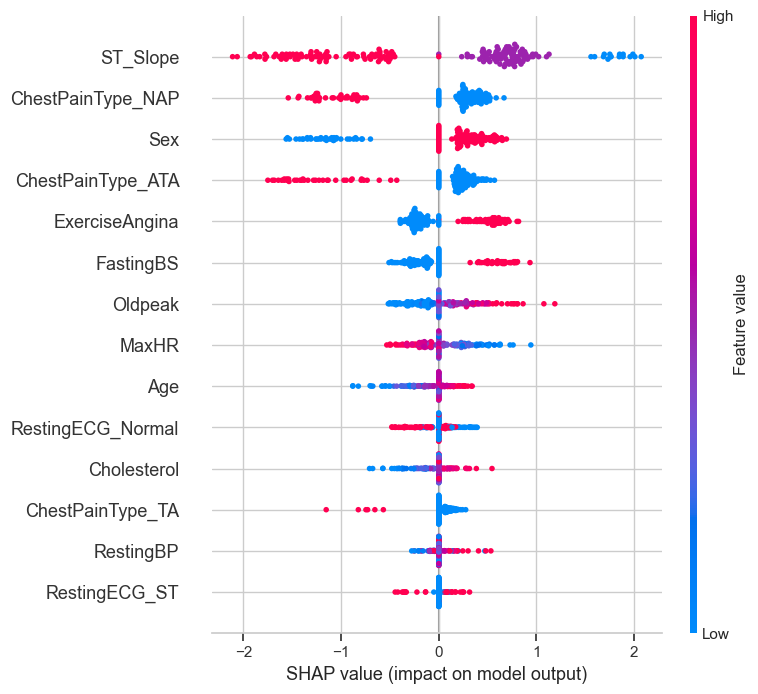

In [85]:
# Global feature importance
shap_values_global = explainer.shap_values(X_test)
shap.summary_plot(shap_values_global, X_test, feature_names=X.columns)


In [86]:
# Compare top features across samples
top_feats = [np.argsort(np.abs(shap_values[i]))[::-1][:3] for i in range(len(shap_values))]
for i, feats in enumerate(top_feats):
    print(f"Top features for sample {i}: {[X.columns[j] for j in feats]}")


Top features for sample 0: ['ST_Slope', 'Sex', 'ExerciseAngina']
Top features for sample 1: ['ChestPainType_NAP', 'ST_Slope', 'MaxHR']
Top features for sample 2: ['Sex', 'ChestPainType_NAP', 'Age']
Top features for sample 3: ['ST_Slope', 'ChestPainType_NAP', 'MaxHR']


# Q4 - Neural Additive Models
## Q4.1 - NAM Architecture

In [87]:
n_features = X_train.shape[1]
feature_names = X.columns.tolist()

# create one Input & subnet per feature
inputs = []
outputs = []
for i, name in enumerate(feature_names):
    inp = Input(shape=(1,), name=f"inp_{name}")
    x = Dense(32, activation='relu', name=f"dense1_{name}")(inp)
    x = Dense(16, activation='relu', name=f"dense2_{name}")(x)
    out = Dense(1, activation=None, name=f"shape_{name}")(x)
    inputs.append(inp)
    outputs.append(out)

# sum all feature sub‑net outputs + bias
combined = Add(name="sum_features")(outputs)
prob = Activation('sigmoid', name="prediction")(combined)

# assemble model
nam = Model(inputs=inputs, outputs=prob, name="NeuralAdditiveModel")
nam.compile(optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Prepare inputs as list of single‑column arrays
def to_feature_list(X_array):
    return [X_array[:, i].reshape(-1,1) for i in range(X_array.shape[1])]

X_train_list = to_feature_list(X_train)
X_test_list  = to_feature_list(X_test)

#### Training

In [88]:
history = nam.fit(
    X_train_list, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7276 - loss: 0.5443 - val_accuracy: 0.7568 - val_loss: 0.5264
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8110 - loss: 0.4074 - val_accuracy: 0.7432 - val_loss: 0.5239
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8369 - loss: 0.3626 - val_accuracy: 0.7838 - val_loss: 0.5288
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8241 - loss: 0.3666 - val_accuracy: 0.7838 - val_loss: 0.5286
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8576 - loss: 0.3325 - val_accuracy: 0.7973 - val_loss: 0.5301
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8399 - loss: 0.3546 - val_accuracy: 0.7838 - val_loss: 0.5276
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8691 - loss: 0.3184 - val_accuracy: 0.7973 - val_loss: 0.5231
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8531 - loss: 0.3361 - val_accuracy: 0.8108 - val_loss

#### Evaluation

In [89]:
y_pred_proba = nam.predict(X_test_list).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Test Accuracy:          ", accuracy_score(y_test, y_pred))
print("Test F1 Score:          ", f1_score(y_test, y_pred))
print("Test Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Test Accuracy:           0.8858695652173914
Test F1 Score:           0.8955223880597015
Test Balanced Accuracy:  0.8862984218077474

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.89      0.87        82
         1.0       0.91      0.88      0.90       102

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184




---
## Q4.2 - Visualize Feature Importance

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


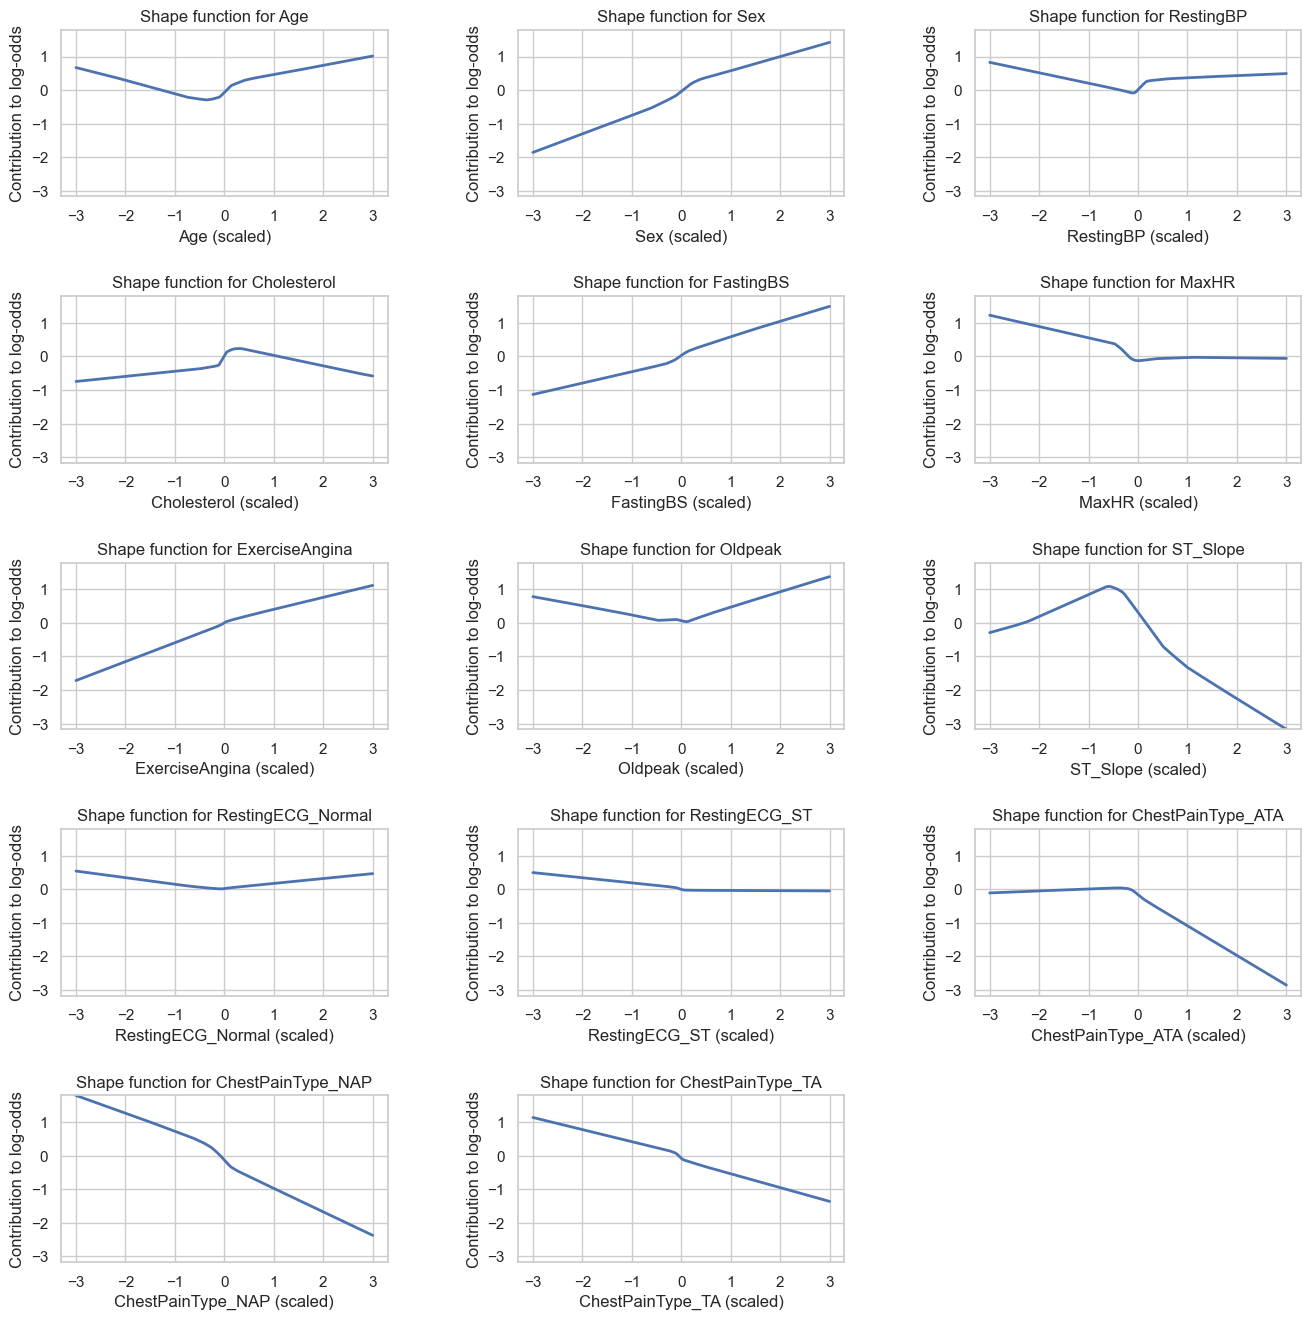

In [91]:
# 1) precompute all the shape-values
grid = np.linspace(-3, 3, 200)
shape_vals = []
for idx, name in enumerate(feature_names):
    X_batch = np.zeros((len(grid), len(feature_names)))
    X_batch[:, idx] = grid
    X_list  = to_feature_list(X_batch)

    shape_model = Model(inputs=nam.inputs,
                        outputs=nam.get_layer(f"shape_{name}").output)
    vals = shape_model.predict(X_list).ravel()
    shape_vals.append(vals)

ymin = min(v.min() for v in shape_vals)
ymax = max(v.max() for v in shape_vals)

# 2) create plot
fig, axes = plt.subplots(
    nrows=5, ncols=3,
    figsize=(16, 16),
    gridspec_kw={
        "hspace": 0.6,   # increase the height padding between rows
        "wspace": 0.4    # (optional) loosen columns too
    }
)

axes = axes.flatten()
for idx, name in enumerate(feature_names):
    ax   = axes[idx]
    vals = shape_vals[idx]

    ax.plot(grid, vals, lw=2)
    ax.set_title(f"Shape function for {name}")
    ax.set_xlabel(f"{name} (scaled)")
    ax.set_ylabel("Contribution to log-odds")
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

# turn off any unused subplots
for ax in axes[len(feature_names):]:
    ax.axis("off")

plt.show()

---
## Q4.3
The Neural Additive Model combines the interpretability of Logistic Regression with the expressive power of neural networks. Unlike Logistic Regression, NAM models each feature’s effect non-linearly using a small subnetwork, enabling it to capture richer individual feature patterns. Compared to MLPs, NAM avoids feature interactions and enforces additive structure, making it significantly more interpretable while sacrificing some predictive complexity.

---
## Q4.4
NAMs are more interpretable than MLPs because they enforce an additive structure over individual features, where each feature is passed through its own isolated subnetwork that models a univariate function. This design means the effect of each feature on the prediction can be visualized independently using a shape function, showing exactly how the feature contributes to the model’s output. In contrast, MLPs entangle all features through dense layers, making it difficult to attribute prediction behavior to specific inputs. Even though both use non-linear neural networks, NAMs retain transparency by structuring non-linearity in a feature-wise decomposable way.